# Whatever

For reference, dimensions of the data:
```python
    # Create a vector of node features including index, type, Vm, Va, Pd, Qd, Gs, Bs
    case['bus'] = x[0]['bus']
    node_features_y = np.zeros((case['bus'].shape[0], 8))
    node_features_y[:, 0] = case['bus'][:, 0]  # index
    node_features_y[:, 1] = case['bus'][:, 1]  # type
    # Vm ----This changes for Load Buses
    node_features_y[:, 2] = case['bus'][:, 7]
    # Va ----This changes for every bus excecpt slack bus
    node_features_y[:, 3] = case['bus'][:, 8]
    node_features_y[:, 4] = case['bus'][:, 2]  # Pd
    node_features_y[:, 5] = case['bus'][:, 3]  # Qd
    node_features_y[:, 6] = case['bus'][:, 4]  # Gs
    node_features_y[:, 7] = case['bus'][:, 5]  # Bs
```

## Load Modules

In [1]:
import os

import torch
import torch_geometric
import matplotlib.pyplot as plt
from tqdm import tqdm

from datasets.PowerFlowData import PowerFlowData
from networks.MPN import MPN, MaskEmbdMultiMPN
from utils.evaluation import load_model

LOG_DIR = 'logs'
SAVE_DIR = 'models'

os.makedirs(LOG_DIR+'/results', exist_ok=True)


In [2]:
feature_names = [
    'index',                # -
    'type',                 # -
    'voltage magnitude',    # --- we care about this
    'voltage angle',        # --- we care about this
    'active power',         # --- we care about this
    'reactive power',       # --- we care about this
    'Gs',                   # -
    'Bs'                    # -
]

feature_names_output = [
    'voltage magnitude',    # --- we care about this
    'voltage angle',        # --- we care about this
    'active power',         # --- we care about this
    'reactive power',       # --- we care about this
    'Gs',                   # -
    'Bs'                    # -
]

## Visualize results
Load saved model and prepare data. Select only 100 samples for simplicity.

In [3]:
#case118
run_id = '20230628-6312'
num_samples = 5000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
testset = PowerFlowData(root='~/data/volume_2/power_flow_dataset', case='118v2', split=[.5, .2, .3], task='test')
print('testset', len(testset))
mean = testset.xymean[0]
std = testset.xystd[0]

testloader = torch_geometric.loader.DataLoader(testset, batch_size=1, shuffle=False)



node_in_dim, node_out_dim, edge_dim = testset.get_data_dimensions()
model = MaskEmbdMultiMPN(
    nfeature_dim=6, 
    efeature_dim=5, 
    output_dim=6, 
    hidden_dim=512, #16 765
    n_gnn_layers=5, 
    K=3, 
    dropout_rate=0.2
).to(device) # 40k params

#case14
# run_id = '20230614-949'
# num_samples = 10000

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# testset = PowerFlowData(root='data', case='118', split=[.5, .2, .3], task='test')
# print('testset', len(testset))
# mean = testset.xymean[0]
# std = testset.xystd[0]

# testloader = torch_geometric.loader.DataLoader(testset, batch_size=1, shuffle=False)

# node_in_dim, node_out_dim, edge_dim = testset.get_data_dimensions()
# model = MPN(
#     nfeature_dim=node_in_dim, 
#     efeature_dim=edge_dim, 
#     output_dim=node_out_dim, 
#     hidden_dim=32, #16 765
#     n_gnn_layers=2, 
#     K=3, 
#     dropout_rate=0.2
# ).to(device) # 40k params

model, _ = load_model(model, run_id, device)

preds = []
targets = []
import time
start = time.time()
with torch.no_grad():
    for i, sample in tqdm(enumerate(testloader)):
        if i > num_samples:
            break
        sample = sample.to(device)
        pred = model(sample)
        preds.append(pred)
        targets.append(sample.y)

end = time.time()
print('time', (end-start)/num_samples)
preds = torch.stack(preds, dim=0).cpu()*std + mean
targets = torch.stack(targets, dim=0).cpu()*std + mean
error = preds - targets
print('preds', preds.shape)

torch.Size([2950000, 9])
Data(x=[2950000, 9], edge_index=[2, 4650000], edge_attr=[4650000, 5], y=[2950000, 8])
testset 25000


5001it [03:05, 26.93it/s]


time 0.037134611082077024
preds torch.Size([5001, 118, 6])


In [4]:
print(mean,std)

tensor([ 9.9958e-01,  1.3879e+01, -4.7110e-03, -2.1571e-02,  0.0000e+00,
         0.0000e+00]) tensor([ 0.0223, 13.9731,  1.2796,  8.3172,  0.0000,  0.0000])


### Error for all scenarios for one node

In [5]:
node_ID = 7
error_node = error[:, node_ID, :]
scenarios = torch.arange(len(error_node))
target_node = targets[:, node_ID, :]
pred_node = preds[:, node_ID, :]

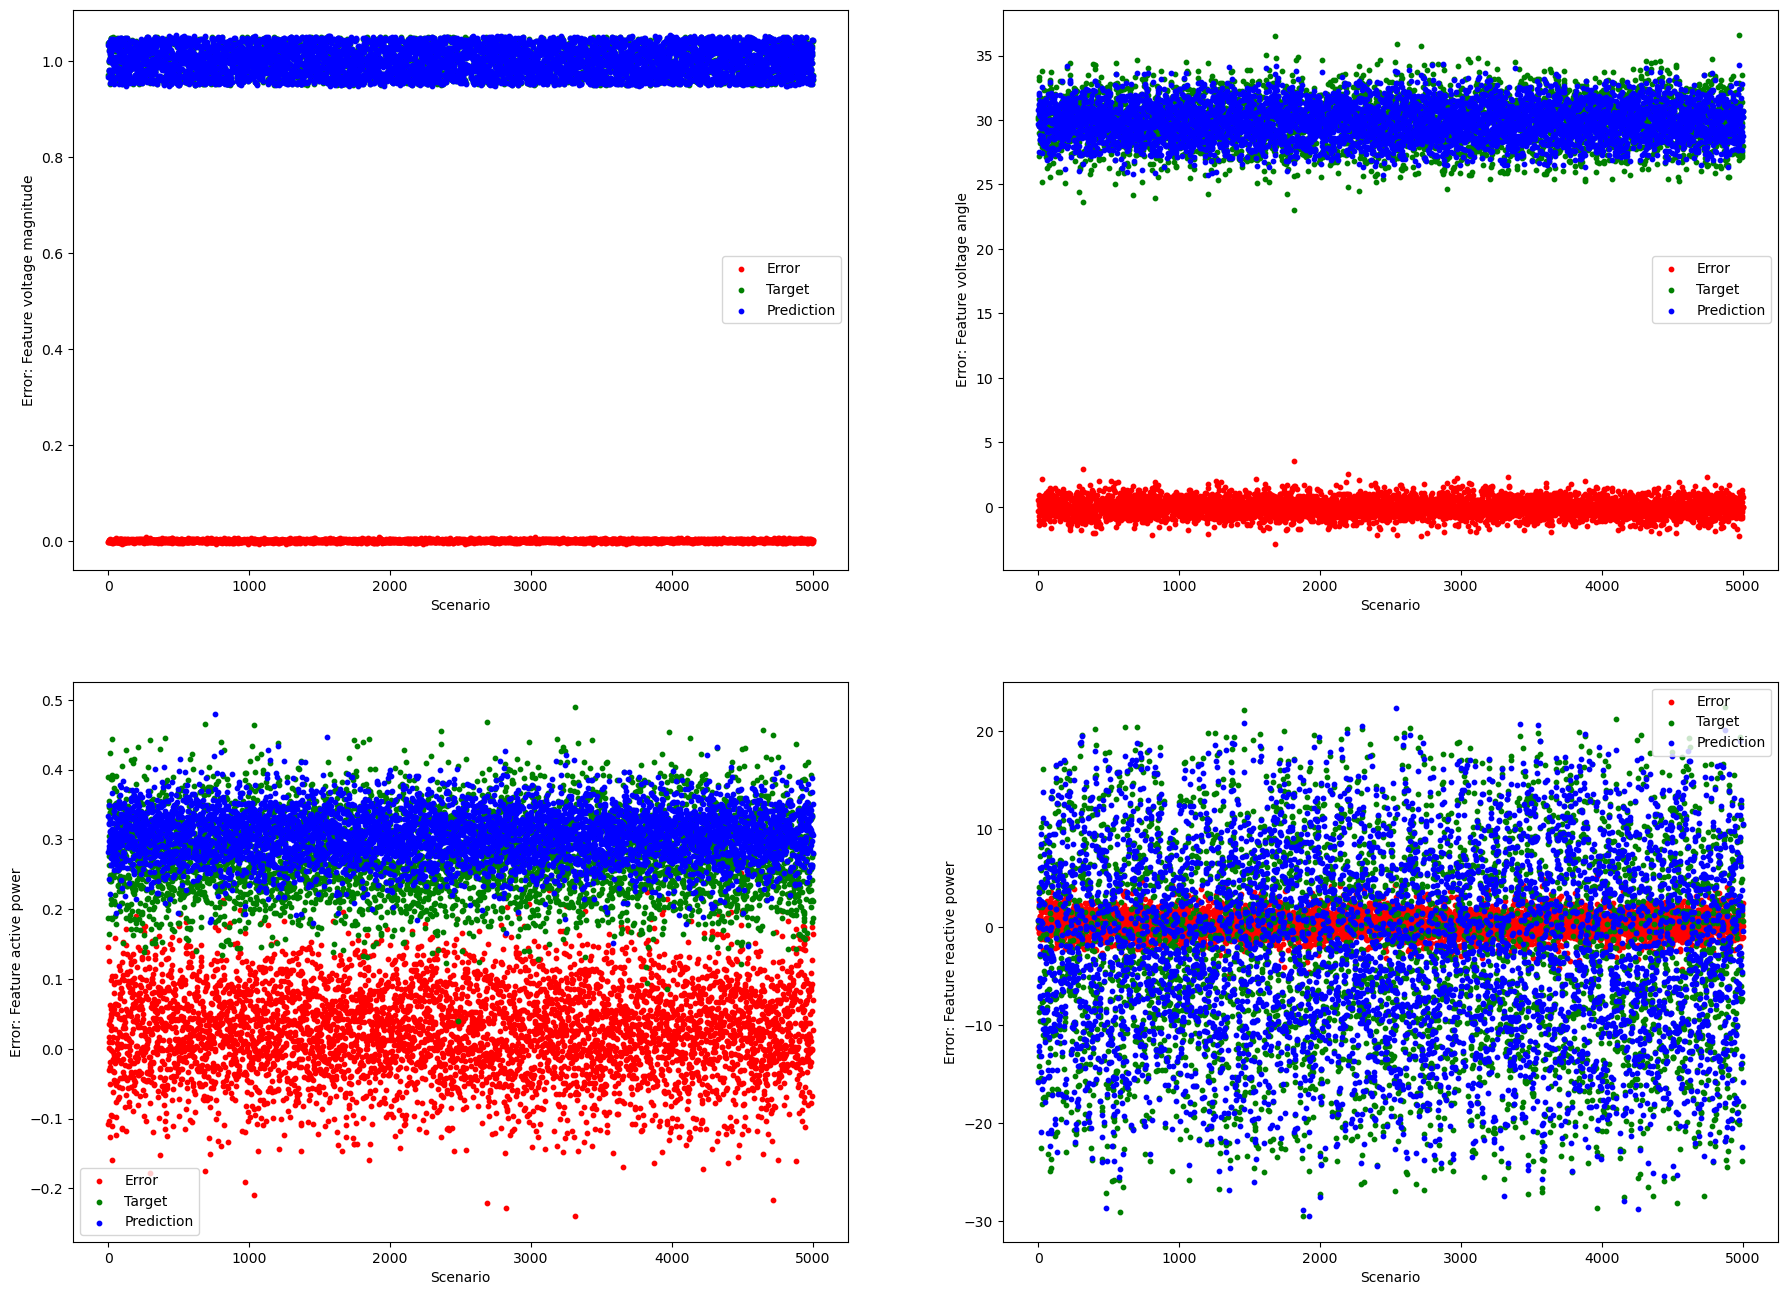

In [6]:
indices = torch.arange(len(error_node))

fig, axes = plt.subplots(2, 2, figsize=(22, 16))
for idx, ax in enumerate(axes.flatten()):
    ax.scatter(scenarios, error_node[indices, idx], c='red', label='Error', s=10)
    ax.scatter(scenarios, target_node[indices, idx], c='green', label='Target', s=10)
    ax.scatter(scenarios, pred_node[indices, idx], c='blue', label='Prediction', s=10)
    ax.set_xlabel('Scenario')
    ax.set_ylabel(f'Error: Feature {feature_names_output[idx]}')
    ax.legend()
    
plt.savefig(LOG_DIR+'/results/'+'error_all_scenarios_'+run_id+'.png')
plt.show()

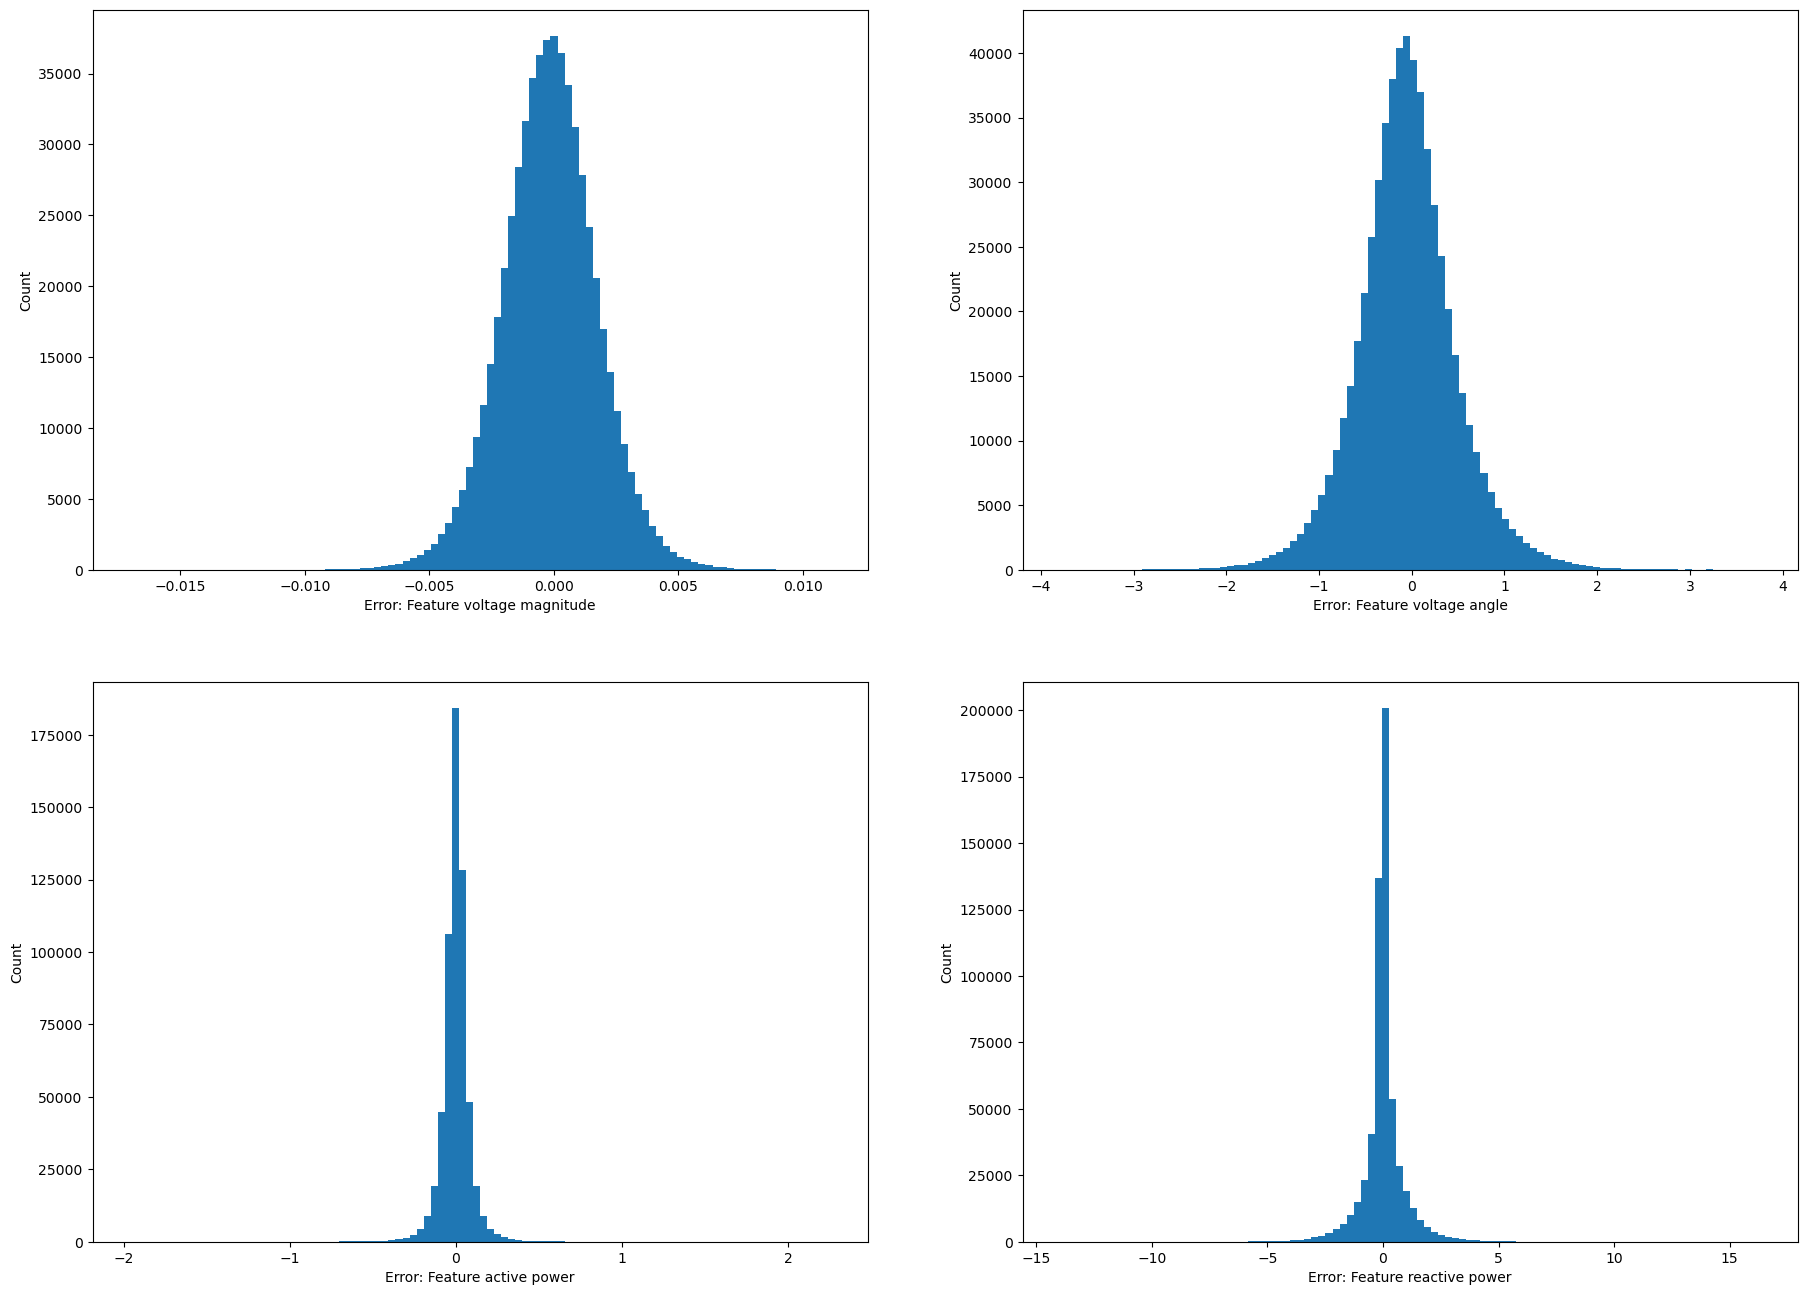

In [7]:
#plot error distribution using hist for every node
fig, axes = plt.subplots(2, 2, figsize=(22, 16))
error_per_feature = error.reshape(-1, 6)
for idx, ax in enumerate(axes.flatten()):
    ax.hist(error_per_feature[:, idx], bins=100)
    ax.set_xlabel(f'Error: Feature {feature_names_output[idx]}')
    ax.set_ylabel('Count')

plt.savefig(LOG_DIR+'/results/'+'error_distribution_'+run_id+'.png')
plt.show()


### Error for all nodes in one scenario

In [8]:
scenario_id = 200
error_scenario = error[scenario_id, :, :]
nodes = torch.arange(len(error_scenario))
target_scenario = targets[scenario_id, :, :]
pred_scenario = preds[scenario_id, :, :]

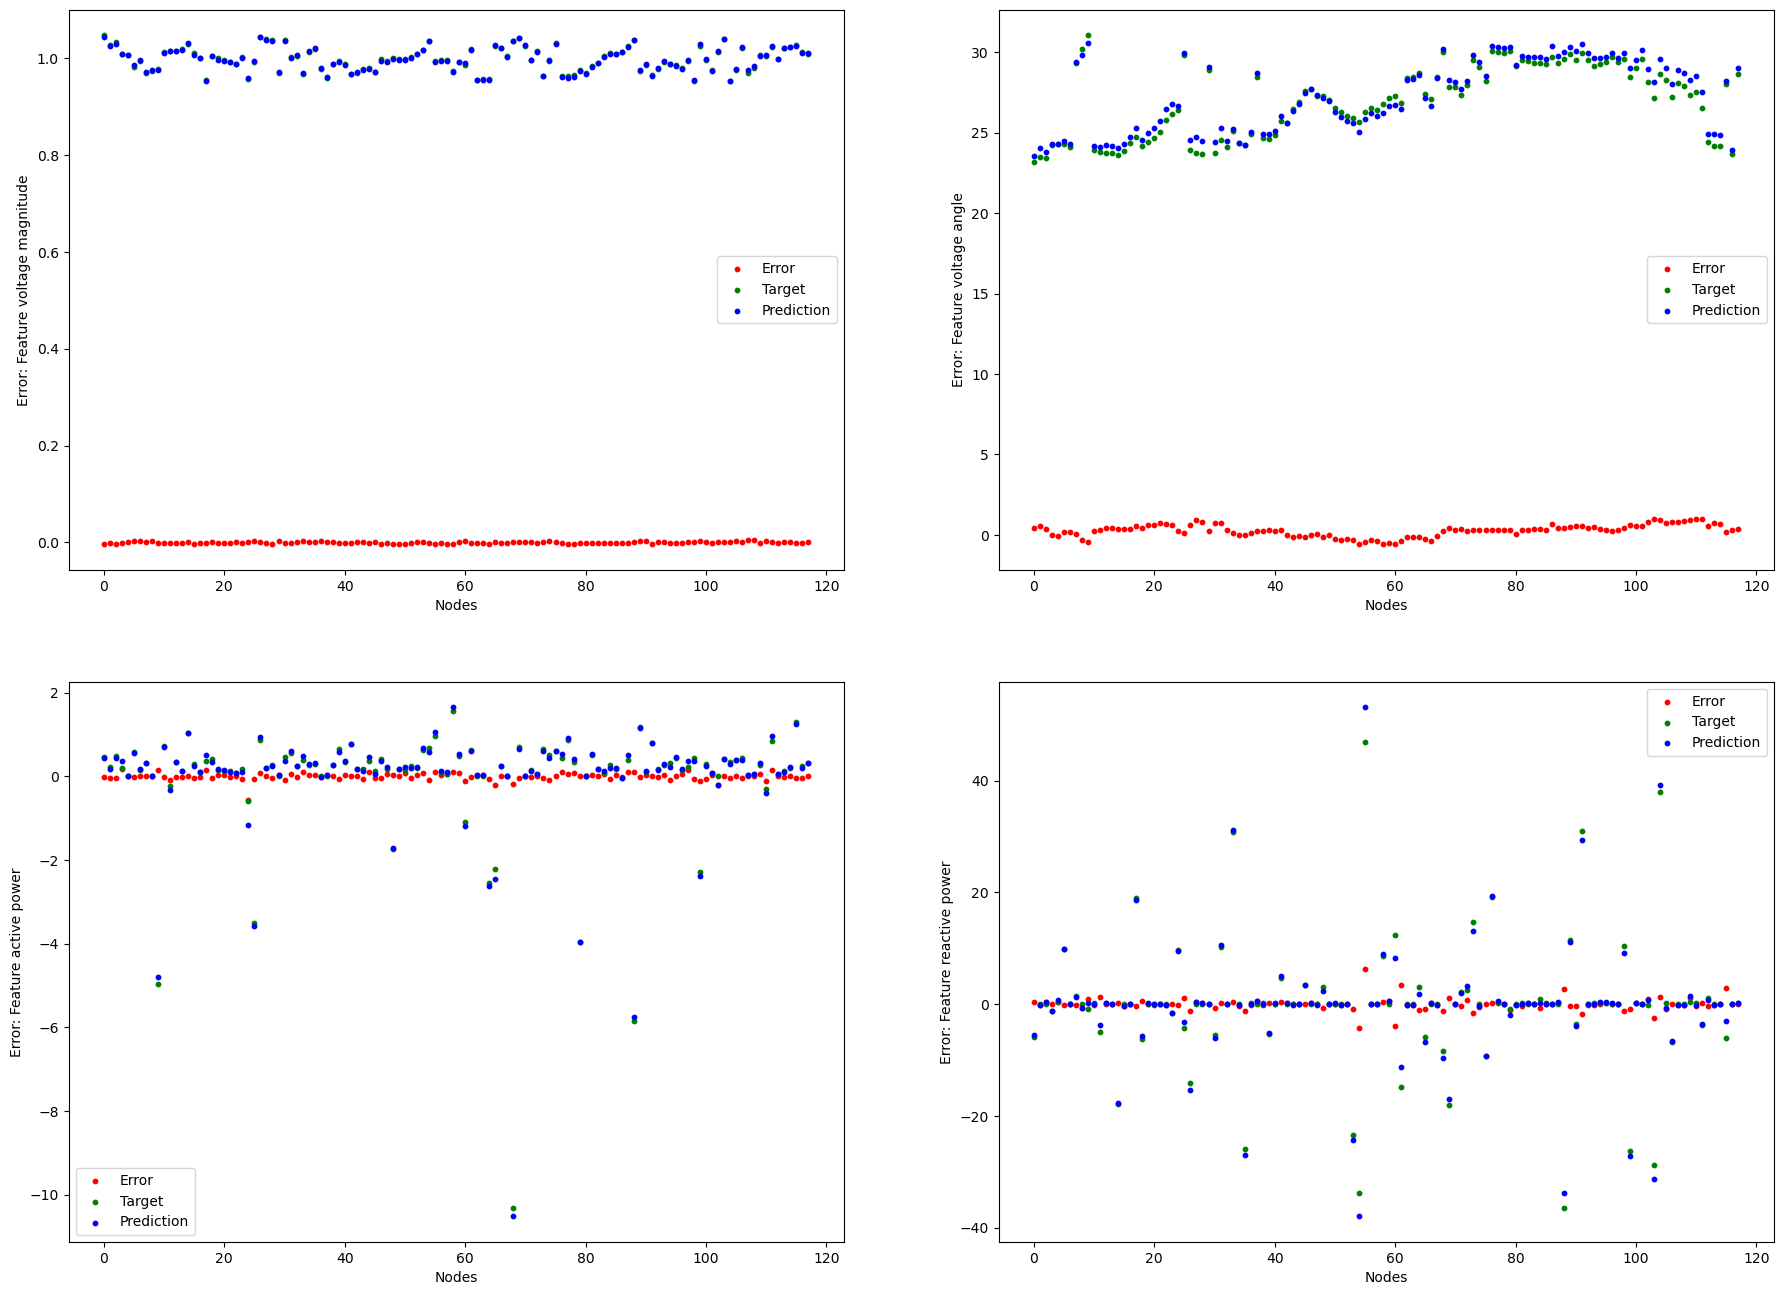

In [9]:
indices = torch.arange(len(error_scenario))

fig, axes = plt.subplots(2, 2, figsize=(22, 16))
for idx, ax in enumerate(axes.flatten()):
    ax.scatter(nodes, error_scenario[indices, idx], c='red', label='Error', s=10)
    ax.scatter(nodes, target_scenario[indices, idx], c='green', label='Target', s=10)
    ax.scatter(nodes, pred_scenario[indices, idx], c='blue', label='Prediction', s=10)
    ax.set_xlabel('Nodes')
    ax.set_ylabel(f'Error: Feature {feature_names_output[idx]}')
    ax.legend()
    
plt.savefig(LOG_DIR+'/results/'+'error_all_nodes_'+run_id+'.png')
plt.show()

**Error per Feature**

In [10]:
# preds = torch.stack(preds, dim=0).cpu()*std + mean
# targets = torch.stack(targets, dim=0).cpu()*std + mean
# error = preds - targets
print('preds', preds.shape)
print('targets', targets.shape)

# get the mean squared error for every feature[:,:,0]
error_vm = error[:,:,0].reshape(-1)
print(error_vm.shape)
loss_vm = torch.mean((error_vm))
print(loss_vm)

loss_va = torch.mean((error[:,:,1])**2)
print(loss_va)

loss_ap = torch.mean((error[:,:,2])**2)
print(loss_ap)

loss_rp = torch.mean((error[:,:,3])**2)
print(loss_rp)


preds torch.Size([5001, 118, 6])
targets torch.Size([5001, 118, 6])
torch.Size([590118])
tensor(-0.0002)
tensor(0.2922)
tensor(0.0081)
tensor(0.8180)
